In [205]:
import matplotlib.pyplot as plt
from matplotlib import colors
import six

import numpy as np
import xarray as xr
import pandas as pd
import os

from stompy import utils
from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base

In [215]:
%matplotlib notebook

In [207]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [208]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.

# Shift to NAVD88 adjusted data:
fn=os.path.join(bml_data_dir,
                '../water_level/elevationNAVD88',
                '2016_NCK_wll_referenced_concat.csv')
df=pd.read_csv(fn)
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
df['depth m']=df['NAVD88']
nck_wll=df.set_index('time')
nck_wll.head()

,year,month,day,hour,minute,second,temp degC,depth m,NAVD88
time,,,,,,,,,
2016-04-06 23:24:00,2016,4,6,23,24,0,13.846,1.258192,1.258192
2016-04-06 23:27:00,2016,4,6,23,27,0,13.269,1.257183,1.257183
2016-04-06 23:30:00,2016,4,6,23,30,0,12.980,1.255166,1.255166
2016-04-06 23:33:00,2016,4,6,23,33,0,12.883,1.253148,1.253148
2016-04-06 23:36:00,2016,4,6,23,36,0,12.787,1.249114,1.249114


In [209]:
# Load QCM data, too -- code taken from pesca_base.py
qcm_pre2016=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output.csv",                                                                     
                        skiprows=[0],usecols=range(7),                                                                                              
                        parse_dates=['Date (PST)'])                                                                                                 
qcm_2016_2017=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output_4.28.2021.csv",                                                         
                          skiprows=[0],usecols=range(14),                                                                                           
                          parse_dates=['Date (PST)'])                                                                                               
# some extra rows in the csv                                                                                                                        
qcm_2016_2017=qcm_2016_2017[ ~qcm_2016_2017['Date (PST)'].isnull() ]                                                                                
qcm=pd.concat([qcm_pre2016,qcm_2016_2017])                                                                                                          

qcm['time']=qcm['Date (PST)'] + np.timedelta64(8,'h') # Shift to UTC.                                                        
# These are both NAVD88, converted ft=>m                                                                                                            
# Prefer the modified data when available:                                                                                                          
ocean_modified=qcm['Modified Ocean Level (feet NAVD88)']                                                                                            
# Otherwise the observed data.                                                                                                                      
ocean_level=qcm['Ocean level (feet NAVD88)']                                                                                                        
qcm['z_ocean']=0.3048 * ocean_modified.combine_first(ocean_level)
qcm['z_ocean_orig']=0.3048 * ocean_level

qcm['z_thalweg']=0.3048 * qcm['Modeled Inlet thalweg elevation (feet NAVD88)']                                                                      
# width                                                                                                                                             
qcm['w_inlet']=0.3048* qcm['Modeled Inlet Width (feet)']                                                                                            

qcm_ds=xr.Dataset.from_dataframe(qcm[ ['time','z_ocean',
                                       'z_ocean_orig','z_thalweg','w_inlet']
                                    ].set_index('time'))                

In [210]:
# Updated test, using BML data
if 1:
    observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')
    # QCM and BML data at NCK differ by about 10.406.
    # This is probably atmospheric pressure? There is still some variability, though
    # some of that could be due to low-pass filtering.
    # Now using adjusted data from Robin that has atmospheric and datum adjustments.
    #observed= observed - 10.406  

In [211]:
models=[ #pesca_base.PescaButano.load('run_salt_20160520-v111'), 
         #pesca_base.PescaButano.load('run_salt_20160520-v113'), 
         #pesca_base.PescaButano.load('run_salt_20160520-v114'),
         #pesca_base.PescaButano.load('run_salt_20160520-v115'),
         #pesca_base.PescaButano.load('run_salt_20160520-v116'),    
         #pesca_base.PescaButano.load('data_mouth_v012'),   
         #pesca_base.PescaButano.load('data_mouth_v013'),
         #pesca_base.PescaButano.load('data_mouth_v014'),
         #pesca_base.PescaButano.load('data_mouth_v020'),
         #pesca_base.PescaButano.load('data_mouth_v015'),
         #pesca_base.PescaButano.load('data_mouth_v017'),
         #pesca_base.PescaButano.load('data_mouth_v018'),
         pesca_base.PescaButano.load('data_salt_filling-v01'),
    
       ]
model0=models[0]

In [212]:
bcs=model0.load_bcs()
ocean_bc=[bc for bc in bcs if bc['name']=='ocean_bc'][0]

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=discharge_salinity_temperature_sorsin
Not implemented: reading BC quantity=discharge_salinity_temperature_sorsin


In [213]:
from stompy.io.local import noaa_coops

mb_gauge=noaa_coops.coops_dataset_product(station=9413450,
                                          product='water_level',
                                          start_date=model0.run_start,
                                          end_date=model0.run_stop,
                                          cache_dir='cache')

an_gauge=noaa_coops.coops_dataset_product(station=9413878,
                                          product='predictions',
                                          interval='hilo',
                                          start_date=model0.run_start,
                                          end_date=model0.run_stop,
                                          cache_dir='cache')

INFO:noaa_coops:Cached   2016-07-01 00:00:00 -- 2016-08-01 00:00:00
INFO:noaa_coops:Cached   2016-08-01 00:00:00 -- 2016-09-01 00:00:00
INFO:noaa_coops:Fetching 2016-09-01 00:00:00 -- 2016-10-01 00:00:00
INFO:noaa_coops:Fetching 2016-10-01 00:00:00 -- 2016-11-01 00:00:00
INFO:noaa_coops:Fetching 2016-11-01 00:00:00 -- 2016-12-01 00:00:00
INFO:noaa_coops:Cached   2016-12-01 00:00:00 -- 2017-01-01 00:00:00
INFO:noaa_coops:Cached   2016-07-01 00:00:00 -- 2016-08-01 00:00:00
INFO:noaa_coops:Fetching 2016-07-01 00:00:00 -- 2016-08-01 00:00:00
INFO:noaa_coops:Cached   2016-08-01 00:00:00 -- 2016-09-01 00:00:00
INFO:noaa_coops:Fetching 2016-08-01 00:00:00 -- 2016-09-01 00:00:00
INFO:noaa_coops:Fetching 2016-09-01 00:00:00 -- 2016-10-01 00:00:00
INFO:noaa_coops:Fetching 2016-10-01 00:00:00 -- 2016-11-01 00:00:00
INFO:noaa_coops:Fetching 2016-11-01 00:00:00 -- 2016-12-01 00:00:00
INFO:noaa_coops:Cached   2016-12-01 00:00:00 -- 2017-01-01 00:00:00


<IPython.core.display.Javascript object>


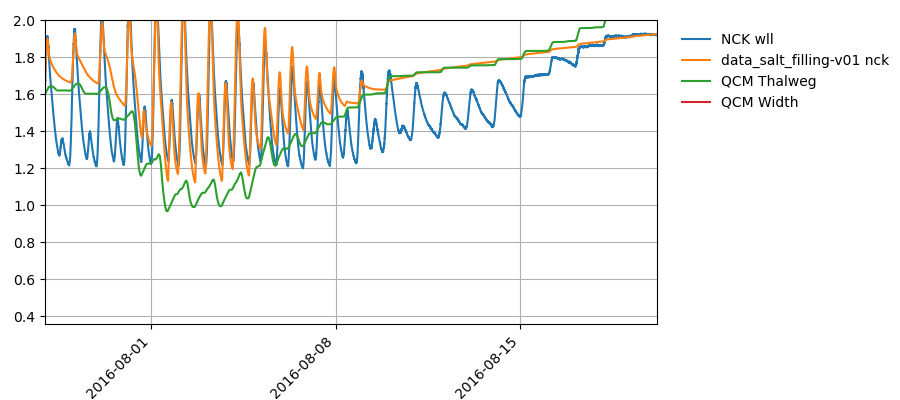

(17006.958333333332, 17134.5625, 0.0, 2.0)

In [218]:
import six
six.moves.reload_module(dc)

sources=[observed]

for model in models: # Model outputs:
    his_ds=xr.open_dataset(model.his_output())

    for model_stn in [ b'nck' ]:
        sel=np.nonzero( his_ds['station_name'].values==model_stn )[0][0]
        predicted=his_ds['waterlevel'].isel(stations=sel)
        predicted=predicted.assign_coords(label=f'{model.run_dir} {model_stn.decode()}')
        sources.append(predicted)
    
    his_ds.close()

# sources.append( ocean_bc['data']['stage'].isel(node=0).assign_coords(label='BC'))

fig=dc.calibration_figure_3panel(sources,trim_time=False,lowpass=False,metric_x=None,
                                 offset_source=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]
ax.axis([16957.813032803748, 16958.72289133207,0,2])

plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

#ax.lines[-1].set_linestyle('--')

if 1: # Add in QCM time series
    #ax.plot(qcm.time,qcm.z_ocean,label='QCM Ocean (adj)')
    #ax.plot(qcm.time,qcm.z_ocean_orig,label='QCM Ocean (orig)')
    #ax.plot(qcm.time,qcm['Modeled Lagoon Level (feet NAVD88)']*0.3048,
    #        label='QCM Model Lagoon')
    ax.plot(qcm.time,qcm['z_thalweg'],label='QCM Thalweg')
    ax.plot(qcm.time,qcm['w_inlet'],label='QCM Width')
    

fig.set_size_inches([9,4],forward=True)
ax.legend(loc='upper left',bbox_to_anchor=[1.02,1], frameon=0)
ax.set_position([0.05,0.19,0.68,0.76])

ax.axis( xmin=his_ds.time.values[0]-np.timedelta64(1,'h'),
         xmax=his_ds.time.values[-1]+np.timedelta64(1,'h'))


#ax.axis((16969.044347661897, 16969.801914782973, 0.21143524775386066, 2.0655442341305115))


In [198]:
# Compare observed lagoon level from QCM and BML 
# This just to establish the offset (which is applied
# above)
if 0:
    qcm['z_lagoon']=qcm['Observed Lagoon Level (feet NAVD88)']*0.3048
    ds_qcm_lagoon=xr.Dataset.from_dataframe(qcm.set_index('time'))['z_lagoon']
    dc.calibration_figure_3panel([ds_qcm_lagoon,observed],trim_time=True,offset_source=None) ;

<IPython.core.display.Javascript object>


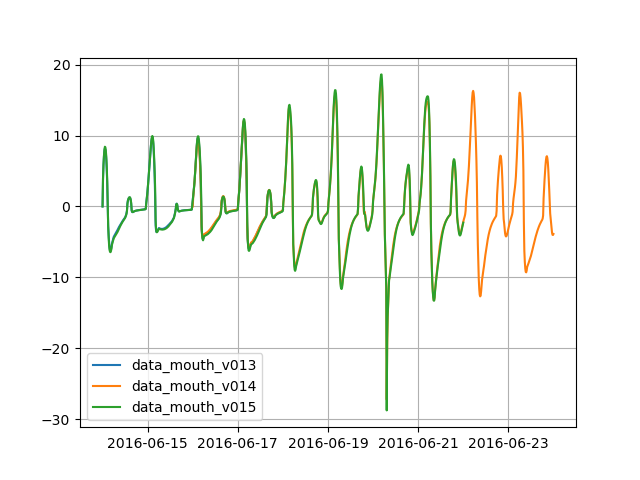

In [183]:
# Compare discharge at the mouth
plt.figure()
for model in models: # Model outputs:
    his_ds=xr.open_dataset(model.his_output())
    his_ds['cross_section']=('cross_section',),his_ds['cross_section_name']

    predicted=his_ds['cross_section_discharge'].sel(cross_section=b'mouth_xs')
    plt.plot(predicted.time,predicted,label=model.run_dir)
    his_ds.close()
plt.legend()

<IPython.core.display.Javascript object>


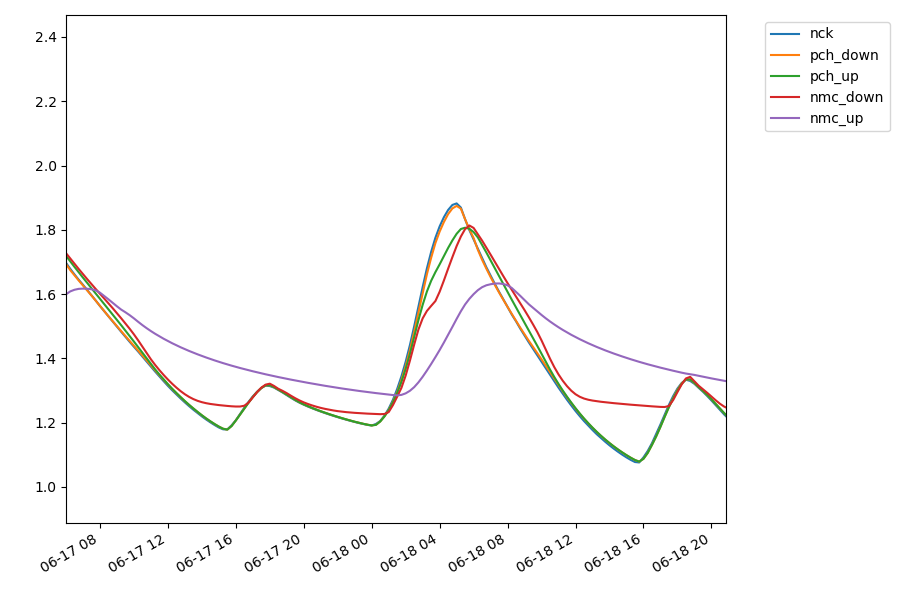

In [223]:
# Lagoon-N Marsh fs gradient
fig,axs=plt.subplots(len(models),1,sharex=True,sharey=True,squeeze=False,
                     figsize=(9,6))
axs=axs[:,0]

for ax,model in zip(axs,models):
    his_ds=xr.open_dataset(model.his_output())
    his_ds['stations']=('stations',),his_ds.station_name.values
    nck=his_ds.waterlevel.sel(stations=b'nck')
    pch_down=his_ds.waterlevel.sel(stations=b'nck')
    his_ds.waterlevel.sel(stations=b'nck')
    for stn in [b'nck',b'pch_down',b'pch_up',b'nmc_down',b'nmc_up']:
        ax.plot(his_ds.time, his_ds.waterlevel.sel(stations=stn),label=stn.decode())
    ax.legend(loc='upper left',bbox_to_anchor=[1.05,1])
    
fig.subplots_adjust(right=0.75)
fig.autofmt_xdate()
fig.tight_layout()

In [181]:

his_ds

<xarray.Dataset>
Dimensions:                                  (cross_section: 10, cross_section_geom_nNodes: 19, gategen_geom_nNodes: 6, gategens: 3, general_structures: 180, nFlowElemContourPts: 4, nFlowElemWithBnd: 4861, nFlowLink: 7783, nFlowLinkPts: 2, nNetLink: 8104, nNetLinkPts: 2, station_geom_nNodes: 514, stations: 514, time: 769)
Coordinates:
    station_x_coordinate                     (stations) float64 5.526e+05 ......
    station_y_coordinate                     (stations) float64 4.124e+06 ......
    station_name                             (stations) |S64 b'pch_up' ... b'...
    cross_section_name                       (cross_section) |S64 b'mouth_xs'...
    general_structure_id                     (general_structures) |S64 b'mout...
    gategen_name                             (gategens) |S64 b'pch_gate' ... ...
  * time                                     (time) datetime64[ns] 2016-06-14...
  * stations                                 (stations) <U18 'pch_up' ... 'th...
  * cross_section                            (cross_section) |S64 b'mouth_xs'...
Dimensions without coordinates: cross_section_geom_nNodes, gategen_geom_nNodes, gategens, general_structures, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, station_geom_nNodes
Data variables:
    FlowElem_xcc                             (nFlowElemWithBnd) float64 5.524...
    FlowElem_ycc                             (nFlowElemWithBnd) float64 4.125...
    FlowElem_zcc                             (nFlowElemWithBnd) float64 -2.34...
    FlowElem_bac                             (nFlowElemWithBnd) float64 177.2...
    FlowElem_xzw                             (nFlowElemWithBnd) float64 5.524...
    FlowElem_yzw                             (nFlowElemWithBnd) float64 4.125...
    FlowElemContour_x                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                              (nFlowElemWithBnd) float64 2.349...
    ElemLink                                 (nNetLink, nNetLinkPts) int32 1 ...
    FlowLink                                 (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                             (nFlowLink) int32 2 2 2 2 ... 2 2 2
    FlowLink_xu                              (nFlowLink) float64 5.524e+05 .....
    FlowLink_yu                              (nFlowLink) float64 4.125e+06 .....
    projected_coordinate_system              int32 -2147483647
    FlowLink_lonu                            (nFlowLink) float64 9.969e+36 .....
    FlowLink_latu                            (nFlowLink) float64 9.969e+36 .....
    FlowElemDomain                           (nFlowElemWithBnd) int32 0 0 ... 4
    FlowLinkDomain                           (nFlowLink) int32 0 0 0 0 ... 0 0 0
    FlowElemGlobalNr                         (nFlowElemWithBnd) int32 24171 ....
    station_id                               (stations) |S64 b'pch_up' ... b'...
    station_geom                             int32 -2147483647
    station_geom_node_count                  (stations) int32 1 1 1 1 ... 1 1 1
    station_geom_node_coordx                 (station_geom_nNodes) float64 5....
    station_geom_node_coordy                 (station_geom_nNodes) float64 4....
    waterlevel                               (time, stations) float64 ...
    bedlevel                                 (stations) float64 0.7667 ... 0....
    x_velocity                               (time, stations) float64 ...
    y_velocity                               (time, stations) float64 ...
    taus                                     (time, stations) float64 ...
    cross_section_geom                       int32 -2147483647
    cross_section_geom_node_count            (cross_section) int32 0 12 ... 0 0
    cross_section_geom_node_coordx           (cross_section_geom_nNodes) float64 ...
    cross_section_geom_node_coordy           (cross_section_

Salinity Comparisons
--

In [219]:
def load_bml(fname):
    df=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/"+fname)
    # UTC
    df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
    # some stations have some bad, -99 values
    df.loc[df.salinity<0,'salinity']=np.nan
    missing=df.time.isnull()
    df=df[~missing]
    df.set_index('time',inplace=True)
    return df

bml_nck_sfc_mcat=load_bml("NCK_sfc_mcat_concatenated.csv")
bml_nck_btm_mcat=load_bml("NCK_btm_mcat_concatenated.csv")
bml_pc3_sfc_sond=load_bml("PC3_sfc_sonde_concatenated.csv")
bml_pc3_btm_sond=load_bml("PC3_btm_sonde_concatenated.csv")

bml_bc1_btm_sond=load_bml("BC1_btm_sonde_concatenated.csv")
bml_bc1_sfc_sond=load_bml("BC1_sfc_sonde_concatenated.csv")

bml_bc3_btm_mcat=load_bml("BC3_btm_mcat_concatenated.csv")
bml_bc3_sfc_mcat=load_bml("BC3_sfc_mcat_concatenated.csv")

bml_ch2_btm_mcat=load_bml("CH2_btm_mcat_concatenated.csv")
bml_ch2_sfc_mcat=load_bml("CH2_sfc_mcat_concatenated.csv")

    

In [220]:
def surface(da):
    # assume data array is {cell or time},layer
    scal=da.values
    valid=np.isfinite(scal)

    surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
    return np.choose(surf_idxs,scal.T)

def bottom(da):
    # assumes data array is time,layer
    scal=da.values
    valid=np.isfinite(scal)
    bed_idxs=np.argmax(valid,axis=1)
    return np.choose(bed_idxs,scal.T) 
    
class FigSalt:
    zoom=(16960.24667031317,
          16962.483944929114,
           -0.5475896244306924,
           36.366318197905606)
    layers=['surface','bottom'] # bed layer, and near-surface layer that is mostly wet.
    layer_styles=['-','--']
    colors=['tab:blue','tab:orange','tab:green','tab:red','tab:brown','tab:purple']
    def load(self,run_dirs,station_name):
        das=[]
        for run_dir in run_dirs:
            his_fn=os.path.join(run_dir,'DFM_OUTPUT_flowfm','flowfm_0000_his.nc')
            ds=xr.open_dataset(his_fn)
            stn=np.nonzero( ds.station_name.values==station_name )[0][0]
            da=ds['salinity'].isel(stations=stn)
            da.attrs['label']=run_dir
            das.append(da)
        return das

    def __init__(self,run_dirs,his_name,bml_sfc,bml_btm,**kws):
        self.fig_dir=os.path.join(run_dirs[0],'fig')
        utils.set_keywords(self,kws)
    
        self.das=self.load(run_dirs,his_name)
        self.his_name=his_name
        
        fig,ax=plt.subplots(figsize=(8,4.5))
        self.fig=fig
        self.ax=ax

        for color,stn_da in zip(self.colors[1:],self.das):
            # Pick out top/bottom finite values.
            scal=stn_da.values
            da_label=stn_da.attrs['label']

            valid=np.isfinite(scal) # time,layer

            for ls,lay in zip(self.layer_styles,self.layers):
                if lay=='surface':
                    surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
                    #lay_scal=np.choose(surf_idxs,scal.T)
                    # np.choose has an upper bound of 32 choices!
                    lay_scal=np.array([scal[ti,li] for ti,li in enumerate(surf_idxs)])
                    z_label="Surface"
                elif lay=='bottom':
                    bed_idxs=np.argmax(valid,axis=1)
                    #lay_scal=np.choose(bed_idxs,scal.T) 
                    lay_scal=np.array( [scal[ti,li] for ti,li in enumerate(bed_idxs)])
                    z_label="Bottom"
                else:
                    lay_scal=scal[:,lay]
                    z=stn_da.zcoordinate_c.isel(laydim=lay).mean().values
                    z_label=f"z={z:.2f} m"
                ax.plot(stn_da.time, lay_scal,
                        label=f"{da_label}\n{z_label}", color=color, ls=ls)
            # Nan transitions:
            bad_salt=np.nonzero(np.diff(np.isnan(lay_scal))>0)[0]
            ax.plot(stn_da.time.values[1:][bad_salt],
                    0*bad_salt,'kx')
            
        # BML Data
        for ls,lay in zip(self.layer_styles,self.layers):
            if lay=='surface':
                ax.plot(bml_sfc.index.values, bml_sfc.salinity,
                        color=self.colors[0],ls=ls,label="BML surface")
            elif lay=='bottom':
                ax.plot(bml_btm.index.values, bml_btm.salinity, 
                        color=self.colors[0],ls=ls,label="BML bottom")
            else:
                print(f"No bml data for layer={lay}")

        ax.legend(loc='upper left',bbox_to_anchor=[1.01,1.0])
        fig.subplots_adjust(right=0.7)
        fig.autofmt_xdate()
        ax.axis( self.zoom )
        name=his_name.decode()
        ax.text(0.03,0.98,name.upper(),transform=ax.transAxes,va='top')
        
        self.save()
    def save(self):
        if (self.fig_dir is not None) and (not os.path.exists(self.fig_dir)):
            os.makedirs(self.fig_dir)
        self.fig.savefig(os.path.join(self.fig_dir,f"salt-timeseries-{self.his_name}.png"))
        

<IPython.core.display.Javascript object>


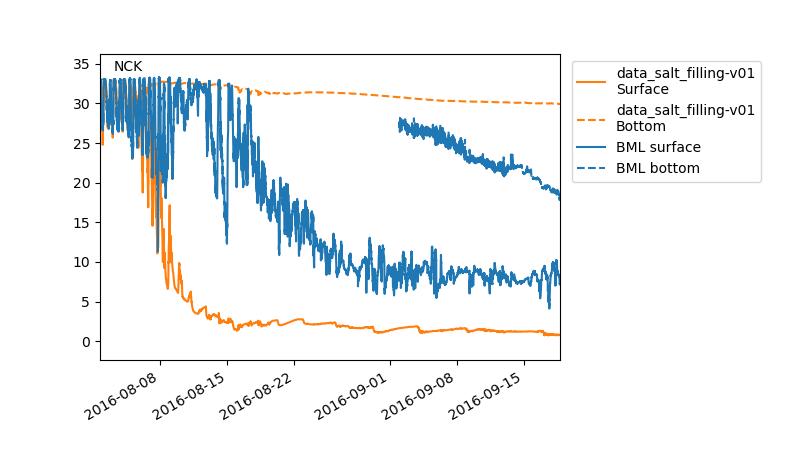

<IPython.core.display.Javascript object>


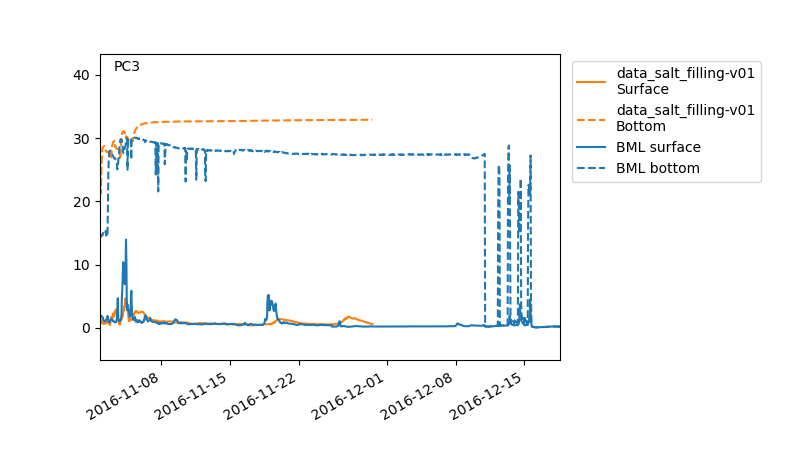

<IPython.core.display.Javascript object>


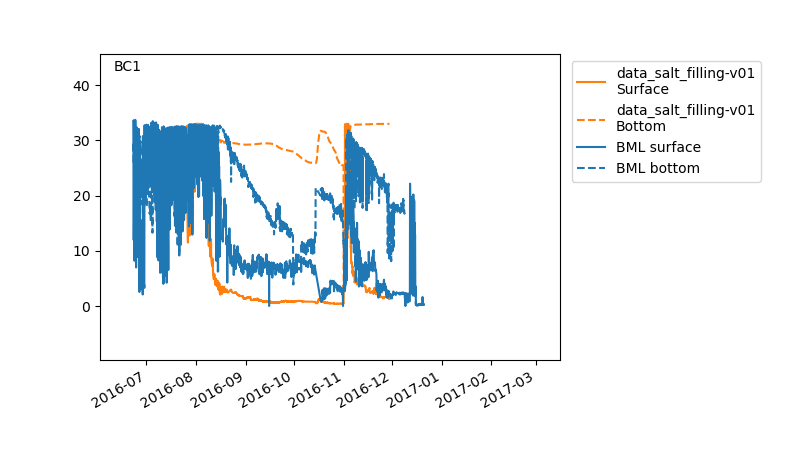

<IPython.core.display.Javascript object>


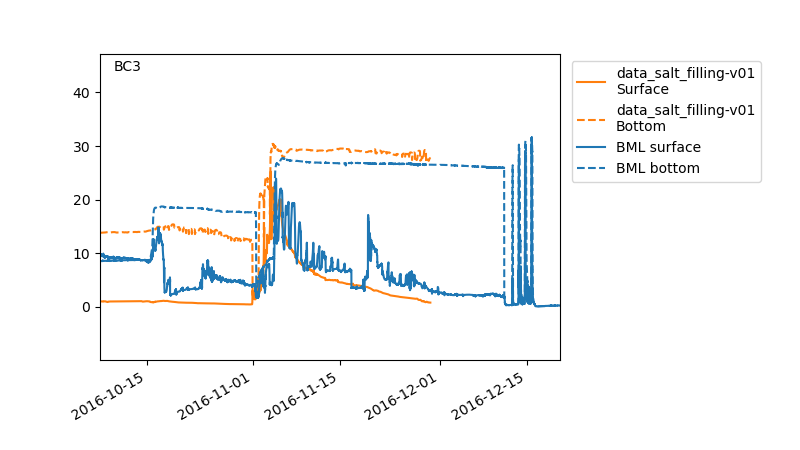

<IPython.core.display.Javascript object>


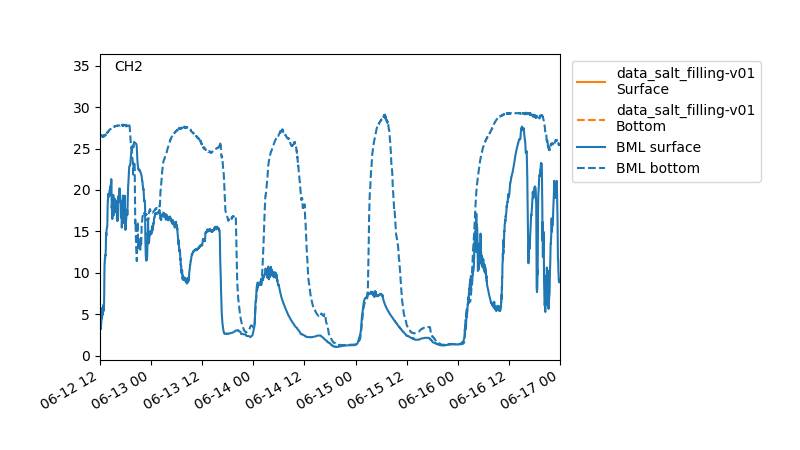

In [222]:
#run_dir="run_salt_20160520-v93"
run_dirs=[models[0].run_dir]

kws=dict(zoom=(16964.5, 16969.0, -0.5, 36.4))
         
FigSalt(run_dirs,b'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat,**kws)
#plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

FigSalt(run_dirs,b'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond,**kws)
#plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

FigSalt(run_dirs,b'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond,**kws)
#plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

FigSalt(run_dirs,b'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat,**kws)
#plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

FigSalt(run_dirs,b'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat,**kws)
#plt.axis(xmin=np.datetime64('2016-06-12 12:00'),xmax=np.datetime64('2016-06-17 00:00'))

In [582]:
six.moves.reload_module(multi_ugrid)
mu=multi_ugrid.MultiUgrid(f"{run_dir}/DFM_OUTPUT_flowfm/*_map.nc",
                         cleanup_dfm=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [602]:
t_start_s=(np.datetime64("2016-06-22T00:00") - mu.time.values[0]) / np.timedelta64(1,'s')
t_start_s, t_start_s+86400*2

(1036800.0, 1209600.0)

In [626]:
fig_dir="figs-20210611"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

<IPython.core.display.Javascript object>


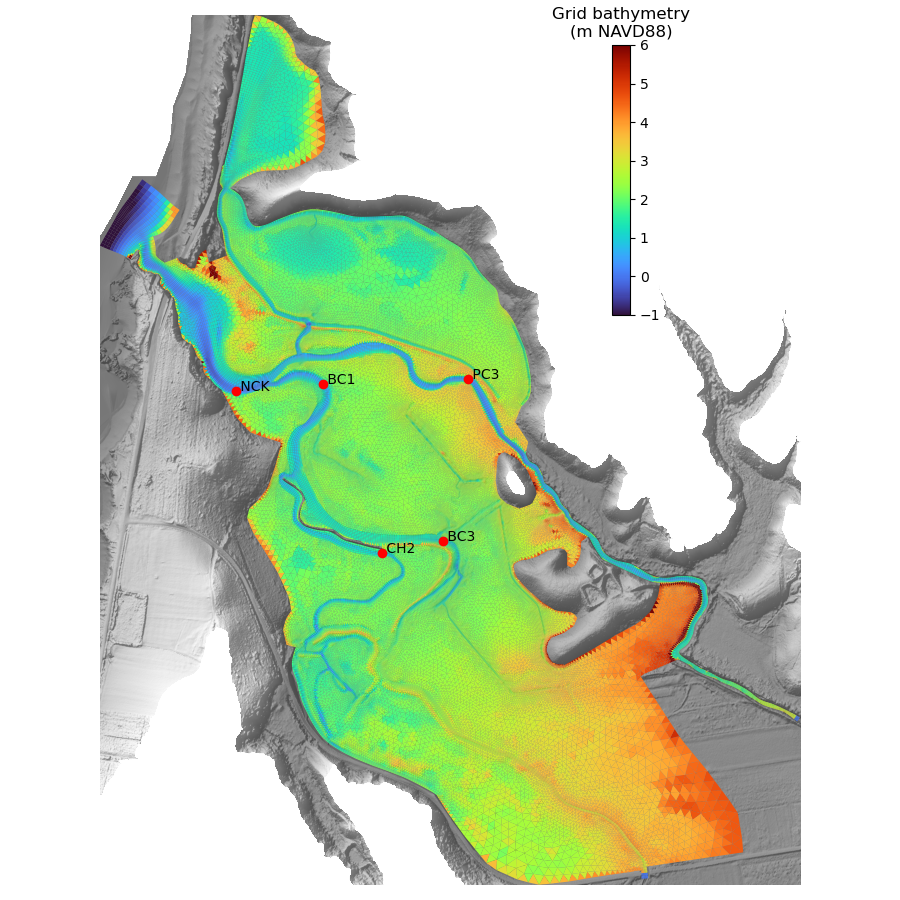

In [627]:
# Make a nice grid/bathy/station figure
from stompy.spatial import field
fig,ax=plt.subplots(1,1,figsize=(9,9))

#zoom=(551932.9888888889, 553361.1838709676, 4123382.36344086, 4125404.205734767)
zoom=mu.grid.bounds()

dem=field.GdalGrid("../../bathy/compiled-dem-existing-20210608-1m.tif")

dem.crop(zoom).plot(ax=ax,cmap='gray',alpha=0.5)
# could put the hillshade above the grid, but it's misleading
dem.crop(zoom).plot_hillshade(ax=ax,plot_args=dict(alpha=0.5))
ccoll=mu.grid.plot_cells(values=mu['mesh2d_flowelem_bl'].values,cmap='turbo',ax=ax,
                         clim=[-1,6])

for stn in ['nck','pc3','bc1','BC3','ch2']:
    stn_idx=list(his_ds.station_name.values).index(stn.encode())
    stn_ds=his_ds.isel(stations=stn_idx)
    x=stn_ds.station_x_coordinate
    y=stn_ds.station_y_coordinate
    
    ax.text(x,y," "+stn.upper())
    ax.plot([x],[y],'ro')
    
ax.axis('off')
fig.tight_layout()

cax=fig.add_axes([0.68,0.65,0.02,0.30])
plt.colorbar(ccoll,cax=cax)
cax.set_title('Grid bathymetry\n(m NAVD88)')

fig.savefig(fig_dir+"/grid-stations-bathy.png",dpi=150)

In [624]:
ccoll.set_clim([-1,6])

In [604]:
mu.dss[0]

<xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 9154, mesh2d_nFaces: 5705, mesh2d_nInterfaces: 29, mesh2d_nLayers: 28, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 3450, time: 19)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.526e+05 ... 5.53e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.123e+06 ... 4.124e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 5.526e+05 ... 5.531e+05
    mesh2d_edge_y                (mesh2d_nEdges) float64 4.123e+06 ... 4.124e+06
    mesh2d_face_x                (mesh2d_nFaces) float64 5.526e+05 ... 5.531e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.123e+06 ... 4.124e+06
  * time                         (time) datetime64[ns] 2016-06-10 ... 2016-06-28
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nInterfaces, mesh2d_nLayers, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 -2147483647
    mesh2d                       int32 -2147483647
    mesh2d_node_z                (mesh2d_nNodes) float64 1.659 1.635 ... 2.219
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 1 2 3 ... 3440 3439
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_edge_faces            (mesh2d_nEdges, Two) float64 1.0 2.0 ... 0.0
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_layer_z               (mesh2d_nLayers) float64 -0.1875 ... 3.188
    mesh2d_interface_z           (mesh2d_nInterfaces) float64 -0.25 ... 3.25
    mesh2d_edge_type             (mesh2d_nEdges) float64 1.0 1.0 1.0 ... 3.0 3.0
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 21.54 22.08 ... 22.51
    mesh2d_flowelem_bl           (mesh2d_nFaces) float64 1.659 1.275 ... 2.214
    mesh2d_flowelem_domain       (mesh2d_nFaces) float64 5.0 5.0 5.0 ... 7.0 7.0
    mesh2d_flowelem_globalnr     (mesh2d_nFaces) float64 6.251e+04 ... 5.284e+04
    timestep                     (time) float64 1.0 0.9346 ... 0.7444 1.695
    mesh2d_Numlimdt              (time, mesh2d_nFaces) float64 ...
    mesh2d_waterdepth            (time, mesh2d_nFaces) float64 0.0 ... 0.0
    mesh2d_s1                    (time, mesh2d_nFaces) float64 ...
    mesh2d_u1                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_u0                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_ucx                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucy                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucz                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucxa                  (time, mesh2d_nFaces) float64 ...
    mesh2d_ucya                  (time, mesh2d_nFaces) float64 ...
    mesh2d_ucmag                 (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_ucmaga                (time, mesh2d_nFaces) float64 ...
    mesh2d_ww1                   (time, mesh2d_nFaces, mesh2d_nInterfaces) float64 ...
    mesh2d_rho                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_q1                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_viu                   (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_diu                   (time, mesh2d_nEdges, mesh2d_nLayers) float64 ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 ...
    mesh2d_sa1                   (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_tem1                  (time, mesh2d_nFaces, mesh2d_nLayers) float64 ...
    mesh2d_turkin1               (time, mesh2d_nEdges, mesh2d_nInterfaces) float64 ...
    mesh2d_vicwwu                (time, mesh2d_nEdges, mesh2d_nInterfaces) float64 ...
    mesh2d_tureps1               (ti

<IPython.core.display.Javascript object>


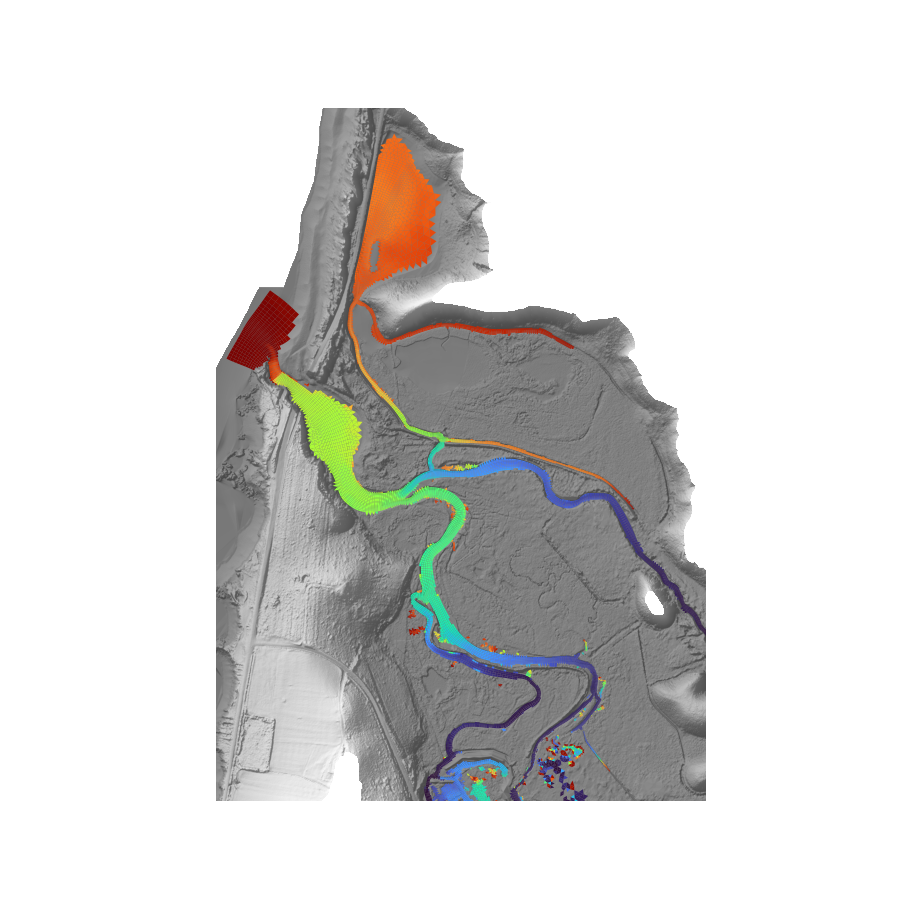

(551932.9888888889, 553361.1838709676, 4123382.36344086, 4125404.205734767)

In [595]:
snap=mu.isel(time=16)

# Find a nice salinity snapshot for a restart to make an animation
mu.grid.plot_cells(values=surface(snap['mesh2d_sa1']),
                   mask=snap['mesh2d_waterdepth'].values>0.01,
                   cmap='turbo',clim=[0,33])

ax.axis(zoom)
ax.axis('off')

In [594]:
snap.time

MultiVar wrapper around <xarray.DataArray 'time' ()>
array('2016-06-25T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2016-06-25
Attributes:
    standard_name:  time

Survey Roughness
--


In [174]:
map_ds=xr.open_dataset('data_mouth_v015/DFM_OUTPUT_flowfm/flowfm_0000_map.nc')
his_ds=xr.open_dataset('data_mouth_v015/DFM_OUTPUT_flowfm/flowfm_0000_his.nc')
his_ds['stations']=('stations',), [s.decode() for s in his_ds.station_name.values]

In [177]:
from stompy.grid import multi_ugrid
mu=multi_ugrid.MultiUgrid('data_mouth_v015/DFM_OUTPUT_flowfm/flowfm_*_map.nc')

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

<IPython.core.display.Javascript object>


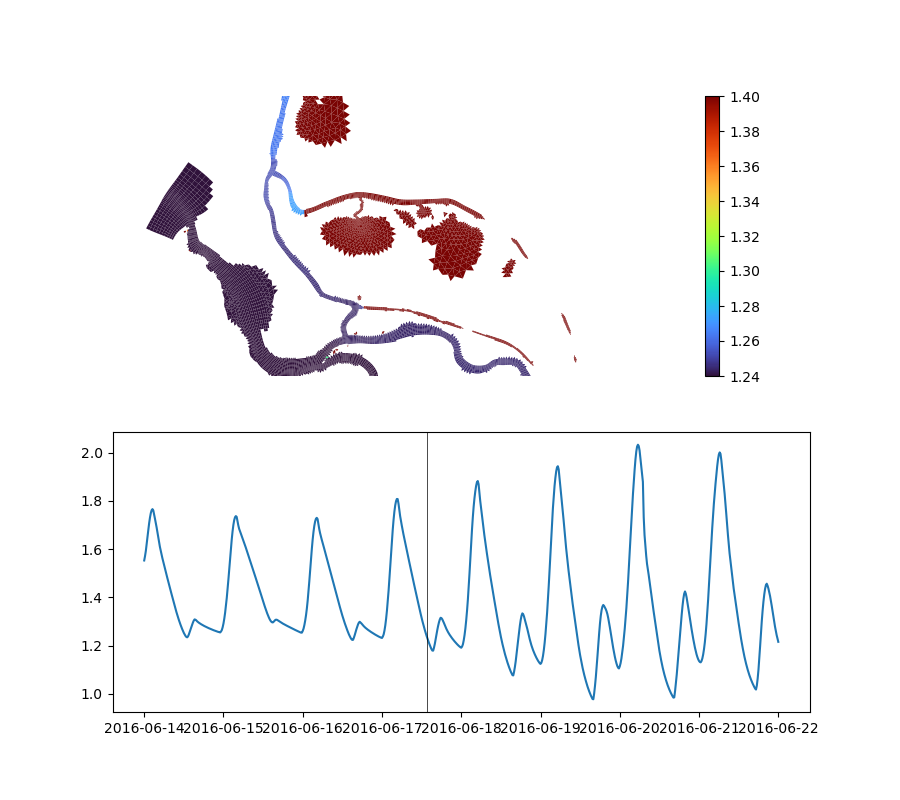

In [178]:
fig,axs=plt.subplots(2,1,figsize=(9,8))

#ccoll=mu.grid.plot_cells(values=mu['mesh2d_czs'].isel(time=0),cmap='turbo',ax=axs[0])
#plt.colorbar(ccoll)

tidx=171
fs=mu['mesh2d_s1'].isel(time=tidx).values.copy()
depth=mu['mesh2d_waterdepth'].isel(time=tidx).values
fs[depth<0.01]=np.nan

ccoll=mu.grid.plot_cells(values=fs,cmap='turbo',ax=axs[0],clim=[1.24,1.4])
plt.colorbar(ccoll,ax=axs[0])

axs[0].axis('equal')
axs[0].axis((551776.708762123, 553455.61138245, 4124084.4775014273, 4124926.9375976487))
axs[0].axis('off')

axs[1].plot(his_ds.time, his_ds.waterlevel.sel(stations='nck'))
axs[1].axvline(mu.time.values[tidx],color='k',lw=0.5)

In [186]:
# are the crest levels smoothly changing, or abruptly?
his_ds=xr.open_dataset('data_mouth_v016/DFM_OUTPUT_flowfm/flowfm_0000_his.nc')

In [189]:
his_ds

<xarray.Dataset>
Dimensions:                                  (cross_section: 70, cross_section_geom_nNodes: 133, gategen_geom_nNodes: 6, gategens: 3, general_structures: 180, nFlowElemContourPts: 4, nFlowElemWithBnd: 4861, nFlowLink: 7783, nFlowLinkPts: 2, nNetLink: 8104, nNetLinkPts: 2, station_geom_nNodes: 3598, stations: 3598, time: 131)
Coordinates:
    station_x_coordinate                     (stations) float64 5.526e+05 ......
    station_y_coordinate                     (stations) float64 4.124e+06 ......
    station_name                             (stations) |S64 b'pch_up' ... b'...
    cross_section_name                       (cross_section) |S64 b'mouth_xs'...
    general_structure_id                     (general_structures) |S64 b'mout...
    gategen_name                             (gategens) |S64 b'pch_gate' ... ...
  * time                                     (time) datetime64[ns] 2016-12-10...
Dimensions without coordinates: cross_section, cross_section_geom_nNodes, gategen_geom_nNodes, gategens, general_structures, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, station_geom_nNodes, stations
Data variables:
    FlowElem_xcc                             (nFlowElemWithBnd) float64 5.524...
    FlowElem_ycc                             (nFlowElemWithBnd) float64 4.125...
    FlowElem_zcc                             (nFlowElemWithBnd) float64 -2.34...
    FlowElem_bac                             (nFlowElemWithBnd) float64 177.2...
    FlowElem_xzw                             (nFlowElemWithBnd) float64 5.524...
    FlowElem_yzw                             (nFlowElemWithBnd) float64 4.125...
    FlowElemContour_x                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                              (nFlowElemWithBnd) float64 2.349...
    ElemLink                                 (nNetLink, nNetLinkPts) int32 1 ...
    FlowLink                                 (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                             (nFlowLink) int32 2 2 2 2 ... 2 2 2
    FlowLink_xu                              (nFlowLink) float64 5.524e+05 .....
    FlowLink_yu                              (nFlowLink) float64 4.125e+06 .....
    projected_coordinate_system              int32 -2147483647
    FlowLink_lonu                            (nFlowLink) float64 9.969e+36 .....
    FlowLink_latu                            (nFlowLink) float64 9.969e+36 .....
    FlowElemDomain                           (nFlowElemWithBnd) int32 0 0 ... 4
    FlowLinkDomain                           (nFlowLink) int32 0 0 0 0 ... 0 0 0
    FlowElemGlobalNr                         (nFlowElemWithBnd) int32 24171 ....
    station_id                               (stations) |S64 b'pch_up' ... b'...
    station_geom                             int32 -2147483647
    station_geom_node_count                  (stations) int32 1 1 1 1 ... 1 1 1
    station_geom_node_coordx                 (station_geom_nNodes) float64 5....
    station_geom_node_coordy                 (station_geom_nNodes) float64 4....
    waterlevel                               (time, stations) float64 ...
    bedlevel                                 (stations) float64 0.7667 ... 0....
    x_velocity                               (time, stations) float64 ...
    y_velocity                               (time, stations) float64 ...
    taus                                     (time, stations) float64 ...
    cross_section_geom                       int32 -2147483647
    cross_section_geom_node_count            (cross_section) int32 0 12 ... 0 0
    cross_section_geom_node_coordx           (cross_section_geom_nNodes) float64 ...
    cross_section_geom_node_coordy           (cross_section_geom_nNodes) float64 ...
    cross_section_discharge                  (time, cross_section) float64 0....
    cross_section_cumulative

<IPython.core.display.Javascript object>


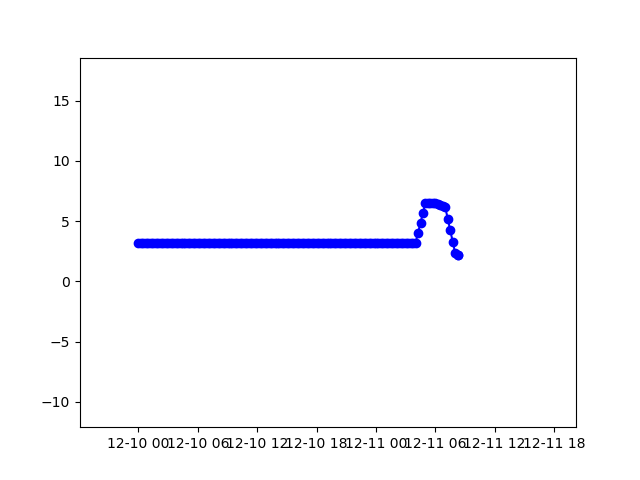

In [192]:
plt.figure()
plt.plot(his_ds.time,his_ds['general_structure_crest_level'].isel(general_structures=0),
        'b-o')